# Polymerase simulation
- Initializes a barbed end at (0, 0) with a random orientation
- Initializes a square domain bounded by [-500, 500] along x and y axes
- Elongation from NPF-bound monomer is diffusion-rate limited.

In [1]:
# Imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def simulate_ppr_wh2_polymerase(actin_concentration = 1.0, npf_count = 1000):
    # Set up variables and constants.
    xy_mat = np.array([0.0, 0.0])
    orientation_alpha = np.pi * np.random.rand()
    dxdy_mat = np.array([np.cos(orientation_alpha), np.sin(orientation_alpha)])
    length_increment = 2.7
    diffusion_coefficient = 1000
    elongation_rate_constant = 5.0
    loading_rate_constant = 10.0
    dissociation_rate_constant = 3.0
    elongation_rate = elongation_rate_constant * actin_concentration
    loading_rate = loading_rate_constant * actin_concentration
    npf_position_mat = 1000 * np.random.rand(npf_count, 2) - 500
    is_ppr_loaded_row = np.zeros(npf_count, dtype = bool)
    is_ppr_tethered_row = np.zeros(npf_count, dtype = bool)
    is_wh2_loaded_row = np.zeros(npf_count, dtype = bool)
    is_wh2_tethered_row = np.zeros(npf_count, dtype = bool)
    # Kinetic Monte Carlo
    time = 0.0
    total_time = 5.0
    from_solution = 0
    from_surface = 0
    while time < total_time:
        distance_row = np.sqrt(np.sum((npf_position_mat - xy_mat)**2, axis = 1))
        diffusion_rate_row = 4 * diffusion_coefficient / distance_row**2
        ppr_loading_rate_row = loading_rate * ((is_ppr_loaded_row == False) & 
                                               (is_ppr_tethered_row == False))
        ppr_unloading_rate_row = dissociation_rate_constant * ((is_ppr_loaded_row == True) & 
                                                               (is_ppr_tethered_row == False))
        ppr_tethering_rate_row = diffusion_rate_row * ((is_ppr_tethered_row == False) &
                                                       (is_ppr_loaded_row == True) & 
                                                       (is_wh2_tethered_row == False))
        ppr_elongation_rate_row = 10 * dissociation_rate_constant * (is_ppr_tethered_row == True)
        wh2_loading_rate_row = 1e-1 * dissociation_rate_constant * ((is_ppr_loaded_row) & 
                                                                    (is_ppr_tethered_row == False) & 
                                                                    (is_wh2_loaded_row == False) & 
                                                                    (is_wh2_tethered_row == False))
        wh2_unloading_rate_row = dissociation_rate_constant  * ((is_wh2_loaded_row == True) & 
                                                                (is_wh2_tethered_row == False))
        wh2_tethering_rate_row = diffusion_rate_row * ((is_wh2_tethered_row == False) & (is_ppr_tethered_row == False))
        wh2_untethering_rate_row = dissociation_rate_constant * ((is_wh2_tethered_row == True) & (is_wh2_loaded_row == False))
        wh2_elongation_rate_row = 10 * dissociation_rate_constant * ((is_wh2_tethered_row == True) & (is_wh2_loaded_row == True))
        solution_elongation_rate_row = np.array([elongation_rate]) * (np.any(((is_ppr_tethered_row == False) | (is_wh2_tethered_row == False))))
        transition_rate_row = np.hstack((ppr_loading_rate_row, 
                                         ppr_unloading_rate_row, 
                                         ppr_tethering_rate_row, 
                                         ppr_elongation_rate_row,
                                         wh2_loading_rate_row,
                                         wh2_unloading_rate_row,
                                         wh2_tethering_rate_row,
                                         wh2_untethering_rate_row,
                                         wh2_elongation_rate_row, 
                                         solution_elongation_rate_row))
        cumsum_transition_rate_row = np.cumsum(transition_rate_row)
        random_rate = np.random.rand() * cumsum_transition_rate_row[-1]
        rate_index = np.searchsorted(cumsum_transition_rate_row, random_rate)
        quotient, remainder = np.divmod(rate_index, npf_count)
        if quotient == 0:
            is_ppr_loaded_row[remainder] = True
        elif quotient == 1:
            is_ppr_loaded_row[remainder] = False
        elif quotient == 2:
            is_ppr_tethered_row[remainder] = True
        elif quotient == 3:
            is_ppr_tethered_row[remainder] = False
            xy_mat += length_increment * dxdy_mat
        elif quotient == 4:
            is_wh2_loaded_row[remainder] = True
            is_ppr_loaded_row[remainder] = False
        elif quotient == 5:
            is_wh2_loaded_row[remainder] = False
        elif quotient == 6:
            is_wh2_tethered_row[remainder] = True
        elif quotient == 7:
            is_wh2_tethered_row[remainder] = False
        elif quotient == 8:
            xy_mat += length_increment * dxdy_mat
            is_wh2_tethered_row[remainder] = False
            is_wh2_loaded_row[remainder] = False
            from_surface += 1
        elif quotient == 9:
            xy_mat += length_increment * dxdy_mat
            from_solution += 1
        random_number = np.random.rand()
        time_increment = np.log(1 / random_number) / cumsum_transition_rate_row[-1]
        time += time_increment
        if xy_mat[0] > 500.0:
            xy_mat[0] -= 1000.0
        if xy_mat[0] < -500.0:
            xy_mat[0] += 1000.0
        if xy_mat[1] > 500.0:
            xy_mat[1] -= 1000.0
        if xy_mat[1] < -500.0:
            xy_mat[1] += 1000.0
    growth_rate = 60e-3 * length_increment * (from_solution + from_surface) / total_time
    surface_solution_ratio = from_surface / from_solution
    return growth_rate, surface_solution_ratio

In [3]:
no_points = 4
no_replicates = 3
npf_count_row = np.linspace(1000, 5000, no_points, dtype=int)
growth_rate_row = np.zeros((no_points, no_replicates))
surface_solution_ratio_row = np.zeros((no_points, no_replicates))
for i in range(npf_count_row.size):
    for j in range(no_replicates):
        growth_rate_row[i, j], surface_solution_ratio_row[i, j] = simulate_ppr_wh2_polymerase(npf_count = npf_count_row[i])

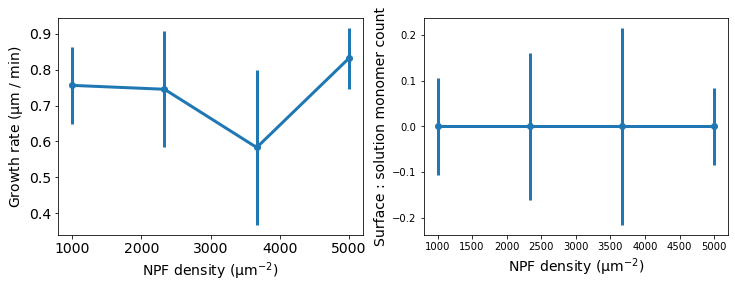

In [9]:
fig_hand, axes_hand = plt.subplots(nrows = 1, ncols = 2)
fig_hand.set_figwidth(12)
axes_hand[0].errorbar(npf_count_row, growth_rate_row.mean(axis = 1), growth_rate_row.std(axis=1), marker='o', linewidth=3)
axes_hand[0].set_xlabel("NPF density ($\mathrm{\mu m^{-2}}$)", fontsize=14)
axes_hand[0].set_ylabel("Growth rate ($\mathrm{\mu m}$ / min)", fontsize=14)
axes_hand[0].tick_params(labelsize=14)
axes_hand[1].errorbar(npf_count_row, surface_solution_ratio_row.mean(axis = 1), growth_rate_row.std(axis=1), marker='o', linewidth=3)
axes_hand[1].set_xlabel("NPF density ($\mathrm{\mu m^{-2}}$)", fontsize=14)
axes_hand[1].set_ylabel("Surface : solution monomer count", fontsize=14)
axes_hand[0].tick_params(labelsize=14)

# Tethering
- Empty WH2 domains should tether barbed ends
- Association rate could be diffusion-rate limited as well
- What is the dissociation rate though?